#**Resolução Lista 5**
---

ARQUIMEDES VINÍCIUS PEREIRA DE FRANÇA MOURA

AUDREY EMMELY RODRIGUES VASCONCELOS



## Instalação do opencv

In [1]:
!pip install opencv-python==4.5.5.62
!pip install opencv-contrib-python==4.5.5.62
!pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importando bibliotecas

In [2]:
import os
import numpy as np
import pandas as pd
from skimage.feature import hog
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

## Questão 1

Usando a plataforma Kaggle, pesquise um base supervisionada de imagens que possa ser usada para treinar um classificador binário de imagens. Esta base deve conter exemplos de duas classes. Considere 70% das amostras para treino, e 30% para teste (método holdout).

a) Usando OpenCV, extraia descritores HOG (Histogram of Gradients), e treine um classificador SVM. Exiba a acurácia atingida no conjunto de teste e a matriz de confusão. Exiba exemplos. Obs.: note que essa abordagem é semelhante ao detector Dalal-Triggs, porém aqui estamos usando-a para classificação de imagens.

Link kaggle:

https://www.kaggle.com/datasets/muratkokludataset/grapevine-leaves-image-dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
main_df = pd.DataFrame()

In [5]:
main_path = '/content/drive/MyDrive/Grapevine_Leaves_Image_Dataset/'
path_Ak = main_path + 'Ak'
path_Ala_Idris = main_path + 'Ala_Idris'
path_Buzgulu = main_path + 'Buzgulu'
path_Dimnit = main_path + 'Dimnit'
path_Nazli = main_path + 'Nazli'

In [6]:
main_df['images'] = os.listdir(path_Ak) + os.listdir(path_Ala_Idris) + os.listdir(path_Buzgulu) + os.listdir(path_Dimnit) + os.listdir(path_Nazli)

In [7]:
classes = []
paths = []
for image in main_df['images']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(main_path+class_+'/'+image)

In [8]:
main_df['classes'] = classes
main_df['path'] = paths

In [9]:
main_df.head()

,images,classes,path
0,Ak (17).png,Ak,/content/drive/MyDrive/Grapevine_Leaves_Image_...
1,Ak (15).png,Ak,/content/drive/MyDrive/Grapevine_Leaves_Image_...
2,Ak (1).png,Ak,/content/drive/MyDrive/Grapevine_Leaves_Image_...
3,Ak (12).png,Ak,/content/drive/MyDrive/Grapevine_Leaves_Image_...
4,Ak (13).png,Ak,/content/drive/MyDrive/Grapevine_Leaves_Image_...


In [10]:
main_df = main_df.drop(main_df[(main_df.classes != 'Ak') & (main_df.classes != 'Buzgulu')].index)

In [11]:
def hog_images(class_name):
    classes_df = main_df[main_df['classes'] ==  class_name].reset_index(drop = True)
    for idx,i in enumerate(np.random.choice(main_df['path'],4)):
        image = cv2.imread(i)
        fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
        fig = plt.figure(figsize=(8, 8))
        plt.suptitle(class_name)
        plt.subplot(2,2,1)
        plt.imshow(hog_image, cmap="gray")
        plt.show()

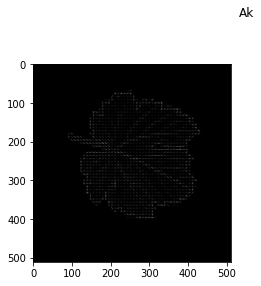

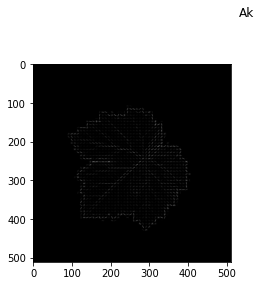

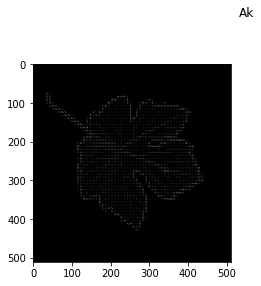

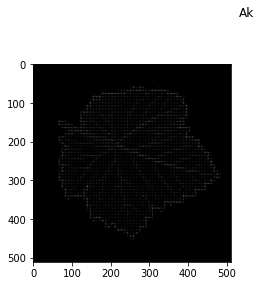

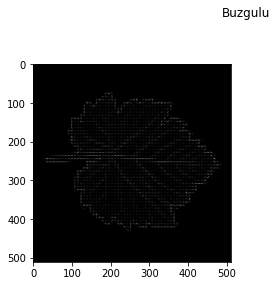

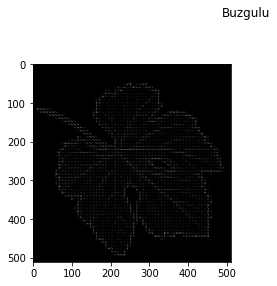

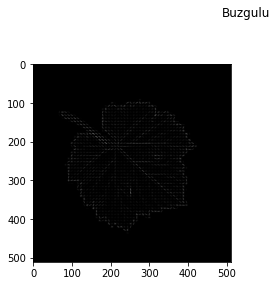

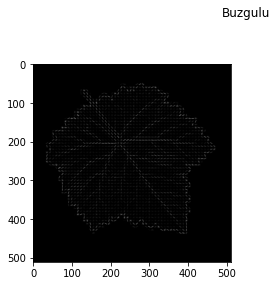

In [12]:
for class_name in main_df['classes'].unique():
    hog_images(class_name)

b) Agora o objetivo é treinar uma CNN. Usando a abordagem de transferência de aprendizado (transfer learning), realize treinamentos usando modelos VGG16, ResNet50, e MobileNetV2 pré-treinados. Compare os resultados usando acurácias e matrizes de confusão. Exiba exemplos.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(main_df[['path', 'classes']], main_df[['classes']], test_size=0.3, random_state=42)

#### **VGG16**

In [14]:
from keras.applications.vgg16 import preprocess_input

In [15]:
vgg_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

In [16]:
train_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 140 validated image filenames belonging to 2 classes.


In [17]:
val_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 60 validated image filenames belonging to 2 classes.


In [18]:
vgg16 = VGG16(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in vgg16.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg16.output)
predictions = Dense(2, activation='softmax')(x)

model_vgg = Model(inputs = vgg16.input, outputs = predictions)

In [19]:
model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [20]:
history_vgg = model_vgg.fit(
      train_generator_vgg,
      validation_data=val_generator_vgg,
      epochs=20,
      verbose='auto')

Epoch 1/20
5/5 [==============================] - 110s 21s/step - loss: 0.9135 - accuracy: 0.4429 - val_loss: 0.8207 - val_accuracy: 0.5333
Epoch 2/20
5/5 [==============================] - 100s 23s/step - loss: 0.8177 - accuracy: 0.5000 - val_loss: 0.7779 - val_accuracy: 0.5167
Epoch 3/20
5/5 [==============================] - 99s 20s/step - loss: 0.7490 - accuracy: 0.5786 - val_loss: 0.7257 - val_accuracy: 0.5500
Epoch 4/20
5/5 [==============================] - 96s 22s/step - loss: 0.6720 - accuracy: 0.6143 - val_loss: 0.6687 - val_accuracy: 0.5833
Epoch 5/20
5/5 [==============================] - 97s 23s/step - loss: 0.5977 - accuracy: 0.7286 - val_loss: 0.7111 - val_accuracy: 0.5833
Epoch 6/20
5/5 [==============================] - 96s 20s/step - loss: 0.5710 - accuracy: 0.7143 - val_loss: 0.5811 - val_accuracy: 0.6500
Epoch 7/20
5/5 [==============================] - 98s 20s/step - loss: 0.5783 - accuracy: 0.6929 - val_loss: 0.5295 - val_accuracy: 0.7500
Epoch 8/20
5/5 [=========

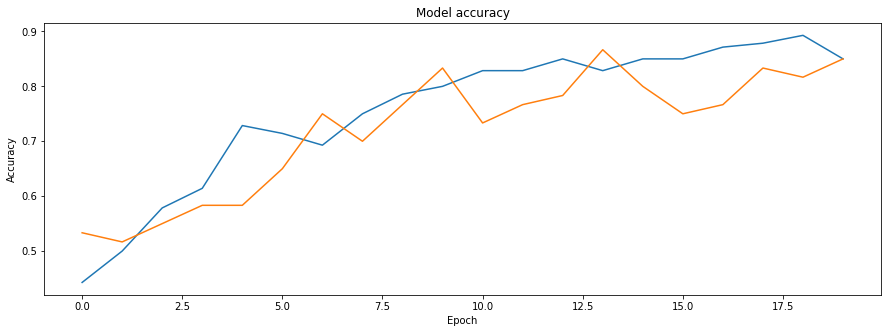

In [21]:
plt.figure(figsize=(15,5))
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

#### **ResNet50**

In [22]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [23]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

In [24]:
train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 140 validated image filenames belonging to 2 classes.


In [25]:
val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 60 validated image filenames belonging to 2 classes.


In [26]:
resnet50 = ResNet50(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in resnet50.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet50.output)
predictions = Dense(2, activation='softmax')(x)

model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)

In [27]:
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [28]:
history_resnet50 = model_resnet50.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=20,
      verbose=2)

Epoch 1/20
5/5 - 51s - loss: 0.8354 - accuracy: 0.5143 - val_loss: 0.7526 - val_accuracy: 0.5333 - 51s/epoch - 10s/step
Epoch 2/20
5/5 - 36s - loss: 0.7499 - accuracy: 0.5143 - val_loss: 0.6907 - val_accuracy: 0.5500 - 36s/epoch - 7s/step
Epoch 3/20
5/5 - 37s - loss: 0.6310 - accuracy: 0.6500 - val_loss: 0.6454 - val_accuracy: 0.6333 - 37s/epoch - 7s/step
Epoch 4/20
5/5 - 35s - loss: 0.5336 - accuracy: 0.7643 - val_loss: 0.5241 - val_accuracy: 0.8000 - 35s/epoch - 7s/step
Epoch 5/20
5/5 - 36s - loss: 0.4844 - accuracy: 0.8429 - val_loss: 0.5025 - val_accuracy: 0.8333 - 36s/epoch - 7s/step
Epoch 6/20
5/5 - 42s - loss: 0.4444 - accuracy: 0.8286 - val_loss: 0.5550 - val_accuracy: 0.6667 - 42s/epoch - 8s/step
Epoch 7/20
5/5 - 38s - loss: 0.4082 - accuracy: 0.8714 - val_loss: 0.4668 - val_accuracy: 0.7833 - 38s/epoch - 8s/step
Epoch 8/20
5/5 - 37s - loss: 0.3757 - accuracy: 0.9143 - val_loss: 0.4945 - val_accuracy: 0.7667 - 37s/epoch - 7s/step
Epoch 9/20
5/5 - 38s - loss: 0.3601 - accuracy:

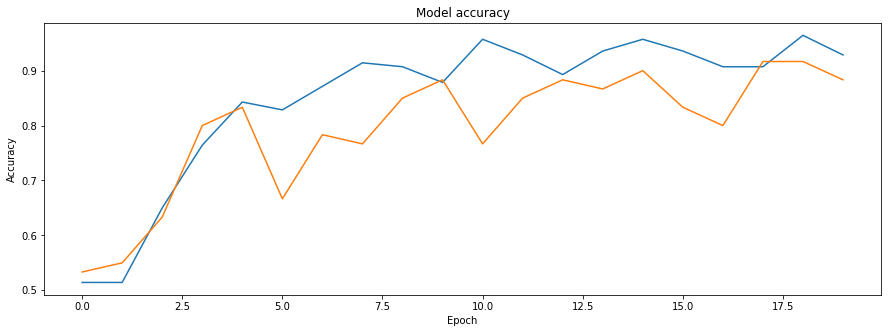

In [29]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Questão 2

O objetivo dessa questão é criar um rastreador de pessoas em vídeos, usando um modelo pré-treinado da YOLO v5.

a) Exiba resultados de detecções em três imagens.

b) Aplique o modelo para detectar pessoas em movimento em um vídeo com a câmera estática. Use o centro das bounding boxes de pessoas detectadas em cada quadro do vídeo para desenhar, sobre a primeira imagem do vídeo, uma curva com a trajetória da(s) pessoa(s). O resultado deve ser semelhante ao da imagem abaixo, onde a curva foi desenhada em vermelho.

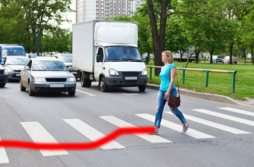